In [8]:
import pandas as pd
from xgboost import XGBClassifier
import ast
from collections import Counter
test_data=pd.read_csv("/Users/jdklee/Documents/AbbVie/aggregate_full.csv")


In [2]:
##read model results
import ast

results=[]
with open("/Users/jdklee/Downloads/results.txt") as fp:
    for line in fp:
        #print(line)
        try:
            print(type(line))
        
            a=ast.literal_eval(line)
            results.append(a)
            
        except:
            try:
                [results.append(ast.literal_eval(i)) for i in line.split("$")]
            except Exception as e:
                print(e)

<class 'str'>


In [3]:
#Models sorted by test roc_auc score
feat_imp_count=20

reactions=[list(i.keys())[0] for i in results]
complete_model_results={}
model_results={}
for indx,r in enumerate(reactions):
    #results[0]["Abdominal discomfort"]["model_evaluations"]
    imp=results[indx][r]["feature_importances"][r]
    i={}
    for k,v in imp.items():
        if v>0:
            i[k]=v
    i=dict(list(i.items())[:feat_imp_count])
    complete_model_results[r]={"ROC":list(results[indx][r].items())[2][1]["result_dict"]["test_roc_auc"],
          "confusion matrix": list(results[indx][r].items())[2][1]["confusion_matrix"],
          "feature importances":i}
    model_results[r]=list(results[indx][r]["model_evaluations"].items())[1][1]
    
sorted_model_results=dict(sorted(model_results.items(), key = lambda i: i[1]["test_roc_auc"] , reverse=True))
sorted_models=dict(sorted(complete_model_results.items(), key = lambda i: i[1]["ROC"] , reverse=True))
sorted_model_results

{'Device expulsion': {'fit_time': 6.868306875228882,
  'score_time': 0.04564228057861328,
  'test_accuracy': 0.990802840646046,
  'test_roc_auc': 0.9957265779350086,
  'test_recall': 0.9839913528273978,
  'test_precision': 0.9925349028379351,
  'test_f1': 0.9881973203289703,
  'test_jaccard': 0.9766850970705265},
 'Epistaxis': {'fit_time': 8.717039680480957,
  'score_time': 0.06277341842651367,
  'test_accuracy': 0.9875875635735534,
  'test_roc_auc': 0.9954840436136795,
  'test_recall': 0.9920044186688759,
  'test_precision': 0.9901942629056947,
  'test_f1': 0.9910840753768173,
  'test_jaccard': 0.9823506811547726},
 'Malignant neoplasm progression': {'fit_time': 11.282893323898316,
  'score_time': 0.0643150806427002,
  'test_accuracy': 0.9351262602319774,
  'test_roc_auc': 0.978620599965416,
  'test_recall': 0.908264281100988,
  'test_precision': 0.9545856202238925,
  'test_f1': 0.9307036411488057,
  'test_jaccard': 0.8705647520451795},
 'Infusion related reaction': {'fit_time': 10.16

In [101]:
sorted_model_results["Drug hypersensitivity"]

{'fit_time': 12.045235586166381,
 'score_time': 0.07969379425048828,
 'test_accuracy': 0.7988721443259909,
 'test_roc_auc': 0.8730255523377615,
 'test_recall': 0.8597589259736482,
 'test_precision': 0.804229333640665,
 'test_f1': 0.830978755795396,
 'test_jaccard': 0.7109376977813732}

In [121]:
sorted_models["Nausea"]

{'ROC': 0.7158816134486126,
 'confusion matrix': [[10196, 19546], [4175, 39506]],
 'feature importances': {'ZUCLOPENTHIXOL ACETATE': 0.02880378,
  'BRINZOLAMIDE\\TIMOLOL MALEATE': 0.02238937,
  'POTASSIUM PERMANGANATE': 0.022389272,
  'DISODIUM FUMARATE': 0.014791044,
  'COD LIVER OIL\\UREA\\ZINC OXIDE': 0.009862524,
  'ASPIRIN\\BUTALBITAL\\CAFFEINE': 0.009699251,
  'RUXOLITINIB': 0.008763924,
  'TOLBUTAMIDE': 0.00756666,
  'AMYLASE\\LIPASE\\PROTEASE': 0.0074642315,
  'FLURBIPROFEN': 0.0073355567,
  'THEANINE': 0.007181436,
  'BIFIDOBACTERIUM SPP.': 0.0070779976,
  'TILIDINE': 0.0070282198,
  'EMICIZUMAB': 0.00679138,
  'PYRIDOXINE\\THIAMINE': 0.006685764,
  'CABOTEGRAVIR': 0.0064874534,
  'BROMOCRIPTINE': 0.0063281497,
  'TENOFOVIR DISOPROXIL': 0.0058842776,
  'CHLORPHENIRAMINE MALEATE\\DIHYDROCODEINE PHOSPHATE\\METHYLEPHEDRINE HYDROCHLORIDE, DL-': 0.0057799076,
  'PROMAZINE': 0.0054378323}}

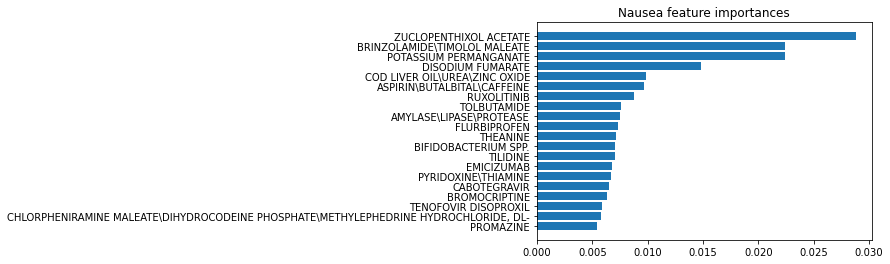

In [124]:
#Feature importances demo!
import matplotlib.pyplot as plt
def get_feat_imp_graph(sorted_models,reaction):
    reaction_dict=sorted_models[reaction]["feature importances"]
    
    keys = list(reaction_dict.keys())
    keys.reverse()
    values = list(reaction_dict.values())
    values.reverse()
    plt.barh(keys, values)
    plt.title("{} feature importances".format(reaction))
    
    
get_feat_imp_graph(sorted_models=sorted_models, reaction="Nausea")

In [125]:



import copy


#Demo on a single row of patient data
def demo_single_row(test_row):

    demo_columns = ['age', 'pt', 'sex', 'wt']
    with open("columns.txt") as fp:
        for line in fp:
            columns=ast.literal_eval(line)

    feature_columns=copy.deepcopy(columns)
    [feature_columns.remove(x) for x in demo_columns]


    results={}
    
    #primaryid=test_row.primaryid
    test_reactions=ast.literal_eval(test_row.pt)
    test_ingredients=ast.literal_eval(test_row.prod_ai)
    test_age=test_row.age
    test_sex=test_row.sex
    test_weight=test_row.wt


    #Set up feature columns
    unseen=pd.DataFrame(columns=columns)
    series={}

    for feat in feature_columns:
        series[feat]=0

    for demo_feat in demo_columns:
        series[demo_feat]=test_row[demo_feat]

    for ingredient in test_ingredients:
        if ingredient in feature_columns:
            #print(ingredient)
            series[ingredient]=1

    unseen=unseen.append(pd.Series(series), ignore_index=True)
    unseen_reactions=ast.literal_eval(list(unseen.pt)[0])
    unseen_reactions=[i for i in unseen_reactions if i in sorted_models.keys()]
    unseen.drop("pt", axis=1, inplace=True)
    #print(len(unseen.columns))

    #get probability
    proba={}
    for reaction in sorted_models.keys():
        model_path="/Users/jdklee/Downloads/jdklee/{}_xgb_model.json".format(reaction)
        model=XGBClassifier()
        model.load_model(model_path)
        result=model.predict_proba(unseen)
        proba[reaction]=result[0][1]
    #results[primaryid]={}
    results["probabilities"]=dict(sorted(proba.items(), key=lambda x:x[1], reverse=True))
    #Evaluate
    import numpy as np
    tp=0
    fp=0
    tn=0
    fn=0
    #print("for ",primaryid)
    for label in unseen_reactions:
        if label in proba:
            if proba[label]>0.5:
                tp+=1
            else:
                fn+=1

            print(label,":","probability=",round(proba[label],2))

    for label,prob in proba.items():
        if label not in unseen_reactions:
            if proba[label]>0.5:
                fp+=1
            else:
                tn+=1
    results["performance"]={}
    results["performance"]["confusion matrix"]=np.array([[tp,fp],[fn,tn]])
    results["performance"]["f1 score"]= (2*tp)/(2*tp+fp+fn)
    results["performance"]["precision"]=tp/(tp+fp)
    results["performance"]["recall"]=tp/(tp+fn)
    return results



test_row=test_data.loc[0]
res=demo_single_row(test_row)

Anaemia : probability= 0.57
Arthralgia : probability= 0.68
Atrial fibrillation : probability= 0.48
Back pain : probability= 0.5
Blood pressure decreased : probability= 0.56
Blood pressure increased : probability= 0.55
Cardiac failure : probability= 0.64
Confusional state : probability= 0.73
Constipation : probability= 0.45
Contusion : probability= 0.55
Cough : probability= 0.65
Decreased appetite : probability= 0.6
Diarrhoea : probability= 0.7
Dizziness : probability= 0.73
Dyspnoea : probability= 0.46
Erythema : probability= 0.52
Fall : probability= 0.75
Fatigue : probability= 0.7
Feeling abnormal : probability= 0.64
Gait disturbance : probability= 0.5
Hypersensitivity : probability= 0.57
Incorrect dose administered : probability= 0.61
Injection site pain : probability= 0.72
Loss of consciousness : probability= 0.43
Malaise : probability= 0.63
Malignant neoplasm progression : probability= 0.27
Nausea : probability= 0.64
Oedema : probability= 0.48
Pain in extremity : probability= 0.34
P

In [130]:
test_row=test_data.loc[0]
test_row.prod_ai
#Age <17 => 1, 17<age<24 => 2, 24<n<65 =>3, age>65 => 4  
#sex 1=male, 2=female


"['OCTREOTIDE ACETATE', 'DILTIAZEM HYDROCHLORIDE', 'CORTISONE\\\\HYDROCORTISONE', 'DABIGATRAN ETEXILATE MESYLATE', 'FLECAINIDE ACETATE', 'CORTICOSTEROID NOS']"

In [106]:
res["probabilities"]


{'Epistaxis': 0.9972932,
 'Flatulence': 0.93116194,
 'Respiratory failure': 0.90813386,
 'Inappropriate schedule of drug administration': 0.8660645,
 'Death': 0.822892,
 'Bronchitis': 0.80364895,
 'Hot flush': 0.7878658,
 'Tremor': 0.7531581,
 'Fall': 0.75113267,
 'Stomatitis': 0.7488543,
 'Dysphagia': 0.7405835,
 'Productive cough': 0.7349366,
 'Dizziness': 0.73247176,
 'Oxygen saturation decreased': 0.72754616,
 'Confusional state': 0.72635424,
 'Vomiting': 0.72478944,
 'Injection site pain': 0.72412133,
 'Myalgia': 0.7201745,
 'Dysgeusia': 0.71974725,
 'Tinnitus': 0.70766157,
 'Feeling hot': 0.70577216,
 'Diarrhoea': 0.70313346,
 'Joint swelling': 0.7016175,
 'Fatigue': 0.7007449,
 'Vertigo': 0.69538134,
 'Cerebrovascular accident': 0.69293743,
 'Sleep disorder': 0.68854845,
 'Arthralgia': 0.6813271,
 'Muscle spasms': 0.6807345,
 'Hypokalaemia': 0.67999476,
 'Interstitial lung disease': 0.6795594,
 'Off label use': 0.67879105,
 'Intentional product misuse': 0.67567796,
 'Gastrooesop

In [107]:
res["performance"]

{'confusion matrix': array([[24, 76],
        [12, 66]]),
 'f1 score': 0.35294117647058826,
 'precision': 0.24,
 'recall': 0.6666666666666666}

In [111]:
def demo_multi_row(test_rows):

    demo_columns = ['age', 'pt', 'sex', 'wt']
    with open("columns.txt") as fp:
        for line in fp:
            columns=ast.literal_eval(line)

    feature_columns=copy.deepcopy(columns)
    [feature_columns.remove(x) for x in demo_columns]


    results={}
    for idx,test_row in test_rows.iterrows():
        
        primaryid=test_row.primaryid
        print("for primary id:",primaryid)
        test_reactions=ast.literal_eval(test_row.pt)
        test_ingredients=ast.literal_eval(test_row.prod_ai)
        test_age=test_row.age
        test_sex=test_row.sex
        test_weight=test_row.wt


        #Set up feature columns
        unseen=pd.DataFrame(columns=columns)
        series={}

        for feat in feature_columns:
            series[feat]=0

        for demo_feat in demo_columns:
            series[demo_feat]=test_row[demo_feat]

        for ingredient in test_ingredients:
            if ingredient in feature_columns:
                series[ingredient]=1

        unseen=unseen.append(pd.Series(series), ignore_index=True)
        unseen_reactions=ast.literal_eval(list(unseen.pt)[0])
        unseen_reactions=[i for i in unseen_reactions if i in sorted_models.keys()]
        if len(unseen_reactions)==0 or len(unseen)==0:
            continue
        unseen.drop("pt", axis=1, inplace=True)

        #get probability
        proba={}
        for reaction in sorted_models.keys():
            model_path="/Users/jdklee/Downloads/jdklee/{}_xgb_model.json".format(reaction)
            model=XGBClassifier()
            model.load_model(model_path)
            result=model.predict_proba(unseen)
            proba[reaction]=result[0][1]
        results[primaryid]={}
        results[primaryid]["probabilities"]=dict(sorted(proba.items(), key=lambda x:x[1], reverse=True))
        #Evaluate
        import numpy as np
        tp=0
        fp=0
        tn=0
        fn=0
        #print("for ",primaryid)
        for label in unseen_reactions:
            if label in proba:
                if proba[label]>0.5:
                    tp+=1
                else:
                    fn+=1

                print(label,":","probability=",round(proba[label],2))

        for label,prob in proba.items():
            if label not in unseen_reactions:
                if proba[label]>0.5:
                    fp+=1
                else:
                    tn+=1
        print("cm:",np.array([[tp,fp],[fn,tn]]))
        
        #print("f1 score:", (2*tp)/(2*tp+fp+fn))
        print("------------------------")
        results[primaryid]["performance"]={}
        results[primaryid]["performance"]["confusion matrix"]=np.array([[tp,fp],[fn,tn]])
        results[primaryid]["performance"]["f1 score"]= (2*tp)/(2*tp+fp+fn)
        results[primaryid]["performance"]["precision"]=tp/(tp+fp)
        results[primaryid]["performance"]["recall"]=tp/(tp+fn)
    return results


test_rows=test_data.iloc[::10000]
a=demo_multi_row(test_rows)

for primary id: 1000808590
Anaemia : probability= 0.57
Arthralgia : probability= 0.68
Atrial fibrillation : probability= 0.48
Back pain : probability= 0.5
Blood pressure decreased : probability= 0.56
Blood pressure increased : probability= 0.55
Cardiac failure : probability= 0.64
Confusional state : probability= 0.73
Constipation : probability= 0.45
Contusion : probability= 0.55
Cough : probability= 0.65
Decreased appetite : probability= 0.6
Diarrhoea : probability= 0.7
Dizziness : probability= 0.73
Dyspnoea : probability= 0.46
Erythema : probability= 0.52
Fall : probability= 0.75
Fatigue : probability= 0.7
Feeling abnormal : probability= 0.64
Gait disturbance : probability= 0.5
Hypersensitivity : probability= 0.57
Incorrect dose administered : probability= 0.61
Injection site pain : probability= 0.72
Loss of consciousness : probability= 0.43
Malaise : probability= 0.63
Malignant neoplasm progression : probability= 0.27
Nausea : probability= 0.64
Oedema : probability= 0.48
Pain in extr

Abdominal pain : probability= 0.72
Diarrhoea : probability= 0.55
cm: [[  2 100]
 [  0  76]]
------------------------
for primary id: 134333061
for primary id: 135125761
Malaise : probability= 0.45
Product substitution issue : probability= 0.64
cm: [[ 1 88]
 [ 1 88]]
------------------------
for primary id: 135912441
Decreased appetite : probability= 0.41
Dyspepsia : probability= 0.16
cm: [[  0 101]
 [  2  75]]
------------------------
for primary id: 136851381
Abdominal pain : probability= 0.79
Constipation : probability= 0.32
cm: [[  1 101]
 [  1  75]]
------------------------
for primary id: 143879612
Alopecia : probability= 0.57
Anxiety : probability= 0.61
Emotional distress : probability= 0.22
Pain : probability= 0.74
cm: [[ 3 99]
 [ 1 75]]
------------------------
for primary id: 153141694
for primary id: 154853673
Abdominal discomfort : probability= 0.57
Cough : probability= 0.77
Diarrhoea : probability= 0.6
Dysphonia : probability= 0.57
Fatigue : probability= 0.7
Headache : prob

In [112]:
def get_agg_metrics(dicto):
    t=[[0,0],[0,0]]
    for k in dicto.keys():
        t+=dicto[k]["performance"]["confusion matrix"]
    [[tp,fp],[fn,tn]]=t
    f1=(2*tp)/(2*tp+fp+fn)
    prec=tp/(tp+fp)
    tpr=tp/(tp+fn)
    tnr=tn/(tn+fp)
    fnr=1-tpr
    acc=(tp+tn)/(tp+tn+fp+fn)
    print("cm:",t)
    print("acc:",acc)
    print("f1:",f1)
    print("prec:",prec)
    print('tpr:',tpr)
    print("tnr:",tnr)
    print("fnr:",fnr)
    print("fpr:", fp/(tn+fp))
    
get_agg_metrics(a)

cm: [[ 168 8451]
 [  89 6244]]
acc: 0.4288389513108614
f1: 0.03785488958990536
prec: 0.01949182039679777
tpr: 0.6536964980544747
tnr: 0.4249064307587615
fnr: 0.3463035019455253
fpr: 0.5750935692412386


In [81]:
[[tp,fp],[fn,tn]]=t
t

array([[ 123, 1838],
       [  49, 1372]])

In [80]:
(2*tp)/(2*tp+fp+fn)

0.11533052039381153

In [82]:
tp/(tp+fp)

0.06272310045894952

In [83]:
tp/(tp+fn)

0.7151162790697675